In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../')
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = umpm.get(root, 'p2_ball_1', user, pwd)

UMPM


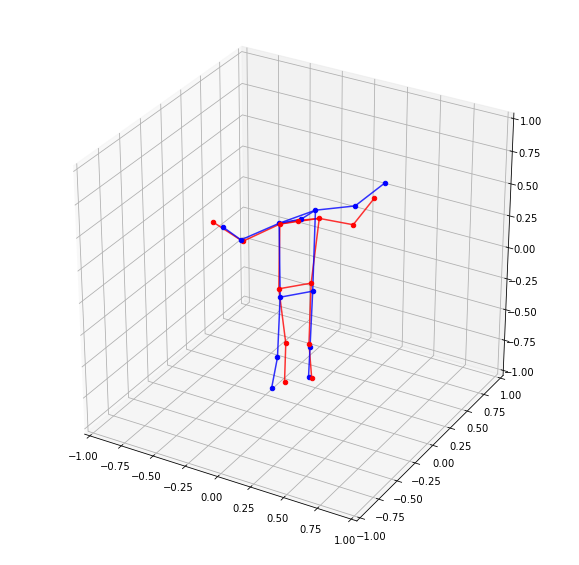

In [2]:
def get_individuals(Y, frame):
    indv1 = Y[frame][0:14,0:3]
    indv2 = Y[frame][14:,0:3]
    return normalize(remove_head(indv1)), \
        normalize(remove_head(indv2))

def remove_head(indv):
    return indv[1:]

def normalize(indv):
    mu = np.mean(indv, axis=0)
    return (indv - mu)/1000  # because we use mm!

def plot_indv(ax, indv, visible=np.ones((13,)), color='red'):
    for (x,y,z), v in zip(indv, visible):
        if v == 1:
            ax.scatter(x,y,z, color=color)
    
    limbs = np.array([
        (1, 2), (1, 5), (2, 5),
        (2, 3), (3, 4), (5, 6), (6, 7),
        (2, 8), (5, 11), (8, 11),
        (8, 9), (9, 10), (11, 12), (12, 13)
    ]) - 1
    for a,b in limbs:
        if visible[a] == 1 and visible[b] == 1:
            p_a = indv[a]
            p_b = indv[b]
            ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], [p_a[2], p_b[2]],
                   color=color, alpha=0.8)
        

indv1, indv2 = get_individuals(Y, 0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

plot_indv(ax, indv1)
plot_indv(ax, indv2, color='blue')

plt.show()

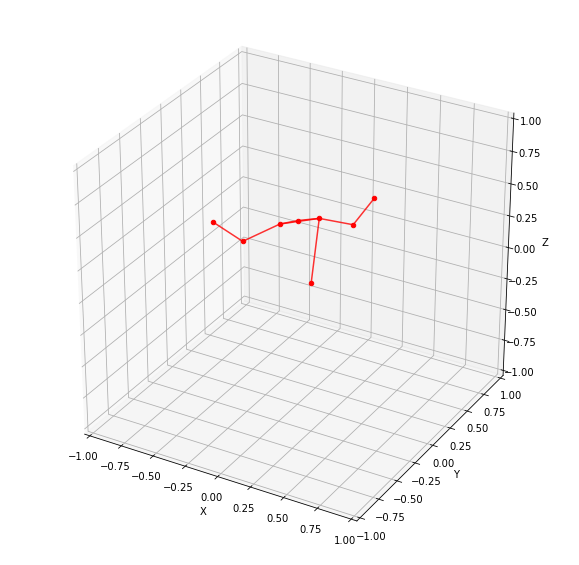

In [45]:
from numpy.random import randint

def disable(indv):
    nbr = randint(1, 3)  # how many limbs to remove
    indv_dis = np.ones((13, 4))
    indv_dis[:,0:3] = indv
    for _ in range(nbr):
        # t=0 -> left arm
        # t=1 -> right arm
        # t=2 -> left foot
        # t=3 -> right foot
        t = randint(0, 4)
        depth = randint(1, 4)
        for d in range(1, depth+1):
            i = (t * 3) + 1 + (3-d)
            indv_dis[i,0] = 0
            indv_dis[i,1] = 0
            indv_dis[i,2] = 0
            indv_dis[i,3] = 0
        
    return indv_dis
    

indv1, indv2 = get_individuals(Y, 0)

indv1_dis = disable(indv1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')

plot_indv(ax, indv1_dis[:,0:3], indv1_dis[:,3])

plt.show()

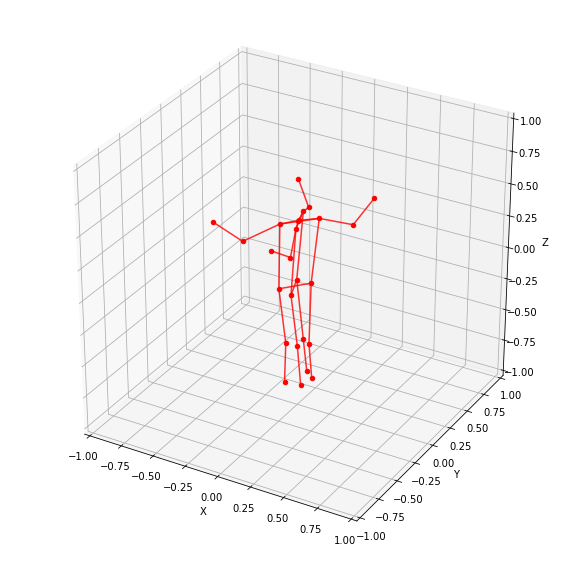

In [4]:
from math import cos, sin

def rot(a, b, c):
    Rx = np.array([
        [1,      0,       0],
        [0, cos(a), -sin(a)],
        [0, sin(a),  cos(a)]
    ])
    Ry = np.array([
        [ cos(b),  0, sin(b)],
        [      0,  1,      0],
        [-sin(b),  0, cos(b)]
    ])
    Rz = np.array([
        [cos(c), -sin(c), 0],
        [sin(c),  cos(c), 0],
        [     0,       0, 1]
    ])
    return Rx @ Ry @ Rz

def rotate(indv, a, b, c):
    R = rot(a, b, c)
    indv_rot = np.zeros_like(indv)
    for i, p in enumerate(indv):
        indv_rot[i] = R @ p
    return indv_rot


indv1, indv2 = get_individuals(Y, 0)

indv1_r = rotate(indv1, 0, 0, 1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')

plot_indv(ax, indv1)
plot_indv(ax, indv1_r)

plt.show()

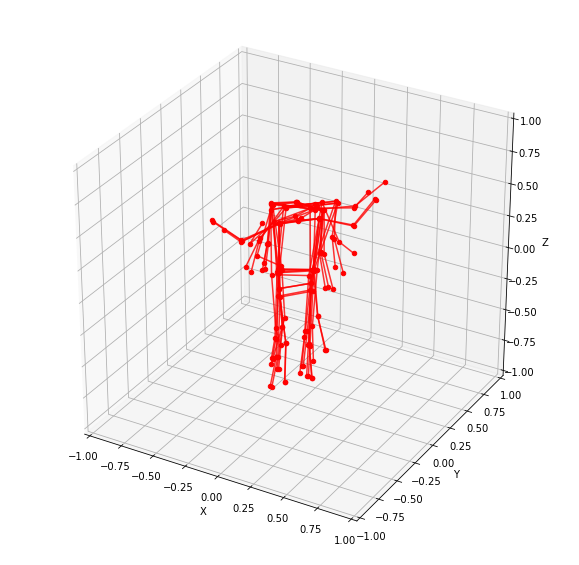

In [5]:
from random import sample

frames = Y.shape[0]
test_set = set(sample(range(frames), 50))


test_X = []
train_X = []
for frame in range(frames):
    indv1, indv2 = get_individuals(Y, frame)
    if frame in test_set:
        test_X.append(indv1)
        test_X.append(indv2)
    else:
        train_X.append(indv1)
        train_X.append(indv2)

test_X = np.array(test_X)
train_X = np.array(train_X)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')

for indv in test_X[0:10]:
    plot_indv(ax, indv)
    
plt.show()

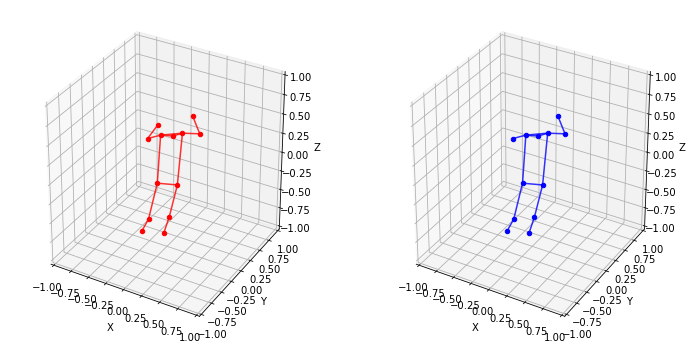

In [170]:
from math import pi
from numpy.random import uniform

def sample_data(X, bs=32, no_rotation=False):
    n = len(X)
    bs = min(n, bs)
    while True:
        y = []
        x = []
        for indv in X[sample(range(n), bs)]:
            indv += uniform(-0.001, 0.001, size=(13, 3))
            if not no_rotation:
                a = uniform(-0.1, 0.1)
                b = uniform(-0.1, 0.1)
                c = uniform(0, 2*pi)
                indv = rotate(indv, a,b,c)
            x.append(disable(indv))
            y.append(indv)
        
        yield np.array(x).reshape(bs, 13*4), \
            np.array(y).reshape(bs, 13*3)

gen = sample_data(test_X, bs=5)

x, y = next(gen)
x_ = x.reshape(5, 13, 4)
indv_o = y.reshape(5, 13, 3)[0]
indv_d = x_[0][:,0:3]


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
plot_indv(ax, indv_o)

ax = fig.add_subplot(122, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
plot_indv(ax, indv_d, x_[0][:,3], color='blue')

    
plt.show()

In [191]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, Flatten, \
    GaussianNoise
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Nadam, Adam, Adadelta
from keras.models import load_model
from os.path import isfile


#filepath = '/tmp/model.h5'
filepath = '/home/DATA/model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]


bs = 32
model = Sequential()
model.add(Dense(units=64, input_dim=52, name='dense1'))
model.add(GaussianNoise(0.1))
model.add(Dropout(0.1))
model.add(Activation('tanh'))
model.add(Dense(units=39, input_dim=52,
                name='output'))

if isfile(filepath):
    model.load_weights(filepath)
    
optimizer = SGD(lr=0.000001, momentum=0.9, nesterov=True)
#optimizer = RMSprop(lr=0.00001)
#optimizer = Nadam()
#optimizer = Adam()
#optimizer = Adadelta()
loss = 'mean_squared_error'
#loss = 'mean_squared_logarithmic_error'
#loss = 'mean_absolute_error'

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['mae'])

model.summary()

history = model.fit_generator(sample_data(train_X, bs=bs), 
                   validation_data=sample_data(test_X, bs=bs),
                   validation_steps=5,
                   steps_per_epoch=100,
                   epochs=100,
                   callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 64)                3392      
_________________________________________________________________
gaussian_noise_27 (GaussianN (None, 64)                0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
activation_84 (Activation)   (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 39)                2535      
Total params: 5,927
Trainable params: 5,927
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0298
Epoch 00001: loss improved from 

Epoch 25/100
 91/100 [==========================>...] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0301
Epoch 00025: loss did not improve
100/100 [==============================] - 1s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0300 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
Epoch 26/100
 96/100 [===========================>..] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0299
Epoch 00026: loss did not improve
100/100 [==============================] - 1s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0299 - val_loss: 0.0013 - val_mean_absolute_error: 0.0241
Epoch 27/100
 92/100 [==========================>...] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0302
Epoch 00027: loss did not improve
100/100 [==============================] - 1s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0301 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
Epoch 28/100
 94/100 [===========================>..] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0301
Epo

Epoch 53/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0300
Epoch 00053: loss did not improve
100/100 [==============================] - 1s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0300 - val_loss: 0.0015 - val_mean_absolute_error: 0.0258
Epoch 54/100
 92/100 [==========================>...] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0298
Epoch 00054: loss did not improve
100/100 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0298 - val_loss: 0.0013 - val_mean_absolute_error: 0.0234
Epoch 55/100
 92/100 [==========================>...] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0298
Epoch 00055: loss did not improve
100/100 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0299 - val_loss: 0.0012 - val_mean_absolute_error: 0.0235
Epoch 56/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0301
Epo

Epoch 81/100
 97/100 [============================>.] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0298
Epoch 00081: loss did not improve
100/100 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0297 - val_loss: 0.0012 - val_mean_absolute_error: 0.0233
Epoch 82/100
 89/100 [=========================>....] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0298
Epoch 00082: loss did not improve
100/100 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0299 - val_loss: 0.0012 - val_mean_absolute_error: 0.0236
Epoch 83/100
 90/100 [==========================>...] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0304
Epoch 00083: loss did not improve
100/100 [==============================] - 1s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0302 - val_loss: 0.0014 - val_mean_absolute_error: 0.0245
Epoch 84/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0300
Epo

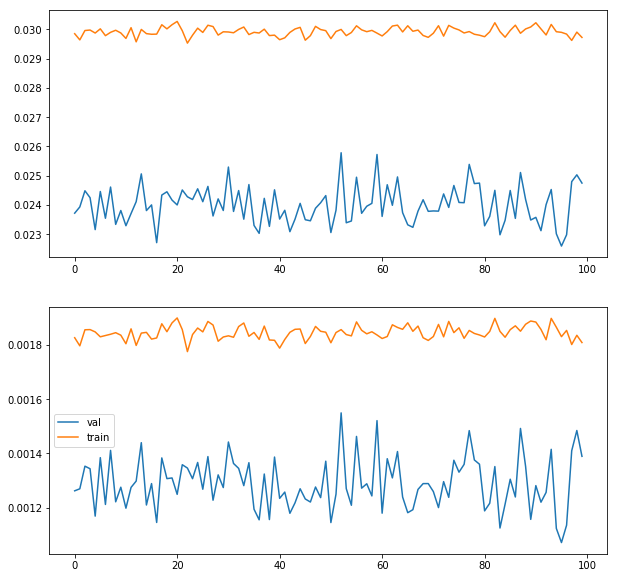

In [192]:
val_mae = history.history['val_mean_absolute_error']
mae = history.history['mean_absolute_error']
val_loss = history.history['val_loss']
loss = history.history['loss']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.plot(range(len(val_mae)), val_mae, label='val')
ax.plot(range(len(mae)), mae, label='train')

ax = fig.add_subplot(212)
ax.plot(range(len(val_loss)), val_loss, label='val')
ax.plot(range(len(loss)), loss, label='train')

plt.legend()
plt.show()

elapsed 0.00012683868408203125


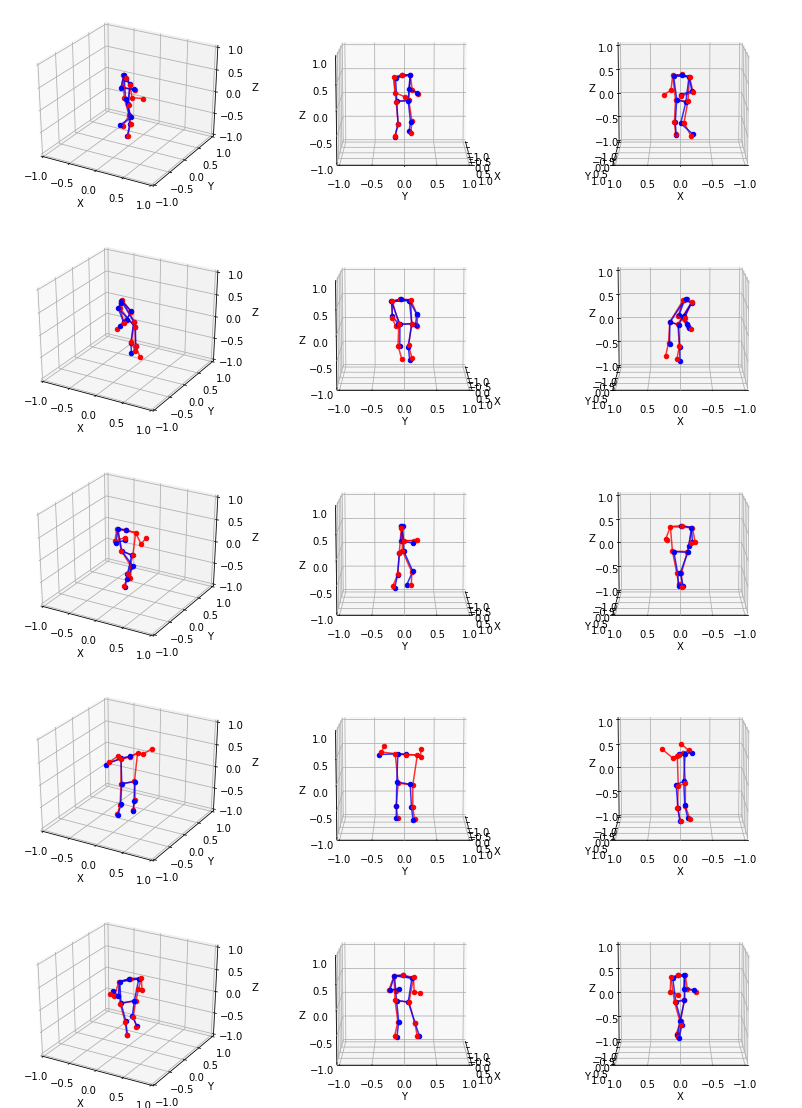

In [194]:

#filepath = '/tmp/model.h5'
model = load_model(filepath)

bs = 5
_start = time()
gen = sample_data(test_X, bs=bs, no_rotation=True)
_end = time()
print('elapsed', _end - _start)

x, y = next(gen)
x_ = x.reshape(bs, 13, 4)
indv_o = y.reshape(bs, 13, 3)[0]
indv_d = x_[0][:,0:3]

y_pred = model.predict(x).reshape(bs, 13, 3)
y_pred1 = y_pred[0]

fig = plt.figure(figsize=(14,20))
for i in range(bs):
    ax = fig.add_subplot(bs, 3, i*3+1, projection='3d')
    ax.set_xlim([-1, 1]); ax.set_xlabel('X')
    ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
    ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
    plot_indv(ax, y_pred[i])
    plot_indv(ax, x_[i][:,0:3], x_[i][:,3], color='blue')
    
    ax = fig.add_subplot(bs, 3, i*3+2, projection='3d')
    ax.view_init(elev=10., azim=0)
    ax.set_xlim([-1, 1]); ax.set_xlabel('X')
    ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
    ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
    plot_indv(ax, y_pred[i])
    plot_indv(ax, x_[i][:,0:3], x_[i][:,3], color='blue')
    
    ax = fig.add_subplot(bs, 3, i*3+3, projection='3d')
    ax.view_init(elev=10., azim=90)
    ax.set_xlim([-1, 1]); ax.set_xlabel('X')
    ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
    ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
    plot_indv(ax, y_pred[i])
    plot_indv(ax, x_[i][:,0:3], x_[i][:,3], color='blue')

    
plt.show()